# Configurations and Importations

In [ ]:
import pymysql.cursors
from Bio.Align.Applications import MuscleCommandline
from Bio import AlignIO
from Bio.Phylo.Applications import FastTreeCommandline
from Bio import Phylo
%matplotlib inline
import scipy.cluster.hierarchy as cl
import scipy.spatial.distance as ssd
import matplotlib
import matplotlib.pyplot as plt
from Bio import Entrez, SeqIO
import time
from termcolor import colored
from lxml import html
import requests

Entrez.email = "vincent.deruaz@master.hes-so.ch"


# Inphinity
## Class

In [9]:
class Inphinity():
    def __init__(self, db_name):
        self.db_name = db_name
        self.connection()
        self.verbose = True
        self.out_dir = './out/'
        
        print('Number of phages loaded: %d' % (self.number_of_phages()))
        
    def print_(self, string):
        if self.verbose:
            print(string)
        
    def connection(self):
        # Connect to the database
        self.connection = pymysql.connect(host='localhost',
                                     user='root',
                                     password='',
                                     db=self.db_name,
                                     charset='utf8mb4',
                                     cursorclass=pymysql.cursors.DictCursor)
        
    def number_of_phages(self):
        cur = self.connection.cursor()
        sql = "SELECT count(*) FROM phage"
        cur.execute(sql)
        
        res = cur.fetchall()
        return res[0]['count(*)']
        
    def simple_execute(self, sql, verbose):
        try:
            with self.connection.cursor() as cursor:
                res = cursor.execute(sql)

                if verbose:
                    self.print_(res)
                    
                return res

            self.connection.commit()
        finally:
            pass
        
    def get_list_pham(self, limit):
        cur = self.connection.cursor()

        if limit == -1:
            sql = "SELECT * FROM pham"
        else:
            sql = "SELECT * FROM pham LIMIT %d" % (limit)
        cur.execute(sql)

        for row in cur:
            self.print_(row)

        return cur
        
    
    def get_list_name_pham(self, limit):
        cur = self.connection.cursor()

        if limit == -1:
            sql = "SELECT name FROM pham GROUP BY name"
        else:
            sql = "SELECT name FROM pham GROUP BY name LIMIT %d" % (limit)
        cur.execute(sql)
        
        list_name = []
        for name in list(cur):
            list_name.append(name['name'])

        return list_name
    
    def get_specific_pham(self, name):
        cur = self.connection.cursor()

        cur.execute("SELECT GeneID FROM pham WHERE name = %s", (name))

        return cur
    
    def get_list_genes(self, gene_ids, verbose):
        cur = self.connection.cursor()
        
        sql = "SELECT * FROM gene WHERE GeneID IN ('%s');" % ( "','".join(gene_ids))
        
        cur.execute(sql)

        if verbose:
            for row in cur:
                self.print_(row)

        return list(cur.fetchall())
    
    def get_phage(self, phage_id, verbose):
        cur = self.connection.cursor()
        
        sql = "SELECT * FROM phage WHERE PhageID = '%s';" % (phage_id)
        
        cur.execute(sql)

        if verbose:
            for row in cur:
                self.print_(row)

        return list(cur.fetchall())
    
    def get_phage_from_gene_id(self, gene_id):
        phage = self.get_phage(self.get_list_genes([gene_id], False)[0]['PhageID'], False)[0]
        return phage
    
    def build_tree(self,pham):
        genes = self.get_genes_from_a_pham(pham)
        self.create_fasta(genes)
        self.align_muscle()
        self.compute_tree()
        self.prepare_tree_fig()
    
    def get_genes_from_a_pham(self, pham):
        pham_list = []
        pham = self.get_specific_pham(pham)
        for id in pham:
            pham_list.append(id['GeneID'])
            self.print_(id)
        genes = self.get_list_genes(pham_list, False)
        
        return genes
        
    def create_fasta(self, genes):
        print('Creation of the FASTA file')
        fasta = open("%sfasta.fa" % (self.out_dir), "w")
        self.print_("Number of Genes: %d" % (len(genes)))
        for gene in genes:
            GeneID = gene['GeneID']
            name = gene['Name']
            description = ">%s - %s" % (GeneID, name)

            translation = gene['translation']

            self.print_(description)
            self.print_(translation)

            fasta.write(description)
            fasta.write('\n')
            fasta.write(translation)
            fasta.write('\n')

        fasta.close()
        
    def align_muscle(self):
        print('Alignment with MUSCLE')
        muscle_loc = r'/home/pa/work/muscle3.8.31_i86linux64' # modifier si nécessaire

        muscle_cline = MuscleCommandline(cmd=muscle_loc,input='%sfasta.fa' % (self.out_dir),out='%sout.aln' % (self.out_dir),clwstrict=True)
        stdout, stderr = muscle_cline()

        muscle_align = AlignIO.read('%sout.aln' % (self.out_dir),'clustal')
        self.print_(muscle_align)
        
    def compute_tree(self):
        print('Compute tree')
        AlignIO.convert('%sout.aln' % (self.out_dir),'clustal','%sintermediate.phy' % (self.out_dir), 'phylip-relaxed')

        cmd_fasttree = r'fasttree'
        fasttree_cmdline = FastTreeCommandline(cmd=cmd_fasttree,fastest=True, \
                                               input='%sintermediate.phy' % (self.out_dir),out='%stree.tre' % (self.out_dir))
        out_log, err_log = fasttree_cmdline()

        self.print_('Out Log:')
        self.print_(out_log)

        self.print_('Error Log')
        self.print_(err_log)

        self.tree = Phylo.read('%stree.tre' % (self.out_dir), 'newick')
        
    def prepare_tree_fig(self):
        print('Prepare Tree Fig')
        self.dmat = []
        self.leaves = [str(cladit) for k,cladit in enumerate(self.tree.get_terminals())]
        for l1,leave1 in enumerate(self.leaves):
            d = []
            for l2,leave2 in enumerate(self.leaves):
                d.append(self.tree.distance(leave1,leave2))
            self.dmat.append(d)
            
    def draw_tree(self):
        print('Draw Tree')
        Z = cl.linkage(ssd.squareform(self.dmat),method='average',metric='euclidean')
        fig = plt.figure(num=None,figsize=(30,25),dpi=250)
        dendro=cl.dendrogram(Z,labels=self.leaves,color_threshold=0.06,leaf_rotation=90,leaf_font_size=10)
        
        self.plt_tree = plt
        
        self.plt_tree.show()
        
    def print_informations_on_phage(self, gene_id):
        phage = self.get_phage_from_gene_id(gene_id)
        color = 'blue'
        
        source = phage['HostStrain']
        if source == 'None':
            color = 'red'
            
            if phage['Accession'] != '':
                phage_ = phage['Accession']
                source = self.get_host_from_genbank(phage_)
            else:
                color = 'yellow'
                phage_ = phage['Name'].split('-')[0]
                source = self.get_informations_from_phage_db(phage_)
            
            print(source)
        
        print("******************************** \
            \nGene ID: %s \nPhage ID: %s \nPhage Name: %s \nPhage Accession: %s" \
            % (gene_id, phage['PhageID'], phage['Name'], phage['Accession']))
        print(colored("HostStrain: %s" % (source), color))        
        print("********************************")
                  
                    
        
    def print_informations_on_phages(self, gene_ids):
        print('===========================')
        print(colored('Blue: Host come from the original database', 'blue'))
        print(colored('Red: Host come from GenBank', 'red'))
        print(colored('Yellow: Host come from Phagedb.org', 'yellow'))
        print('===========================')
        
        for gene_id in gene_ids:
            self.print_informations_on_phage(gene_id)
            
    def get_host_from_genbank(self, genome_id):
        
        try:
            record = Entrez.efetch(db="nuccore", id=genome_id, rettype="gb", retmode="text")

            filename = 'out/genBankRecord.gb'
            with open(filename, 'w') as f:
                f.write(record.read())
            parsed_gb_file = next(SeqIO.parse(filename, "genbank"))

            #print(parsed_gb_file)
            return parsed_gb_file.annotations["source"]
        
        except:
            return 'Not Found'
        
    def get_informations_from_phage_db(self, phage_name):
        page = requests.get('http://phagesdb.org/phages/%s' % (phage_name))
        tree = html.fromstring(page.content)
        
        host = tree.xpath('//*[@id="phageDetails"]/tbody/tr[2]/td[2]/a/em/text()')[0]
        
        return host

    
inphinity = Inphinity('sea_own')


Number of phages loaded: 167


## Listing Pham

In [15]:
list_name = inphinity.get_list_name_pham(-1)
print(list_name)

[7, 8, 9, 10, 11, 17, 18, 19, 20, 25, 26, 27, 29, 30, 38, 47, 48, 49, 51, 52, 53, 54, 57, 64, 65, 67, 68, 69, 72, 77, 79, 81, 82, 87, 88, 93, 94, 95, 97, 99, 100, 101, 103, 105, 106, 108, 112, 118, 120, 124, 125, 128, 134, 137, 139, 141, 144, 145, 146, 149, 151, 152, 153, 155, 156, 163, 164, 166, 169, 174, 175, 176, 177, 178, 179, 180, 181, 184, 186, 187, 189, 191, 192, 194, 195, 199, 202, 203, 208, 209, 210, 211, 212, 213, 217, 218, 219, 220, 221, 222, 224, 225, 226, 227, 229, 230, 231, 232, 235, 236, 237, 239, 240, 241, 242, 243, 245, 247, 248, 250, 252, 253, 255, 261, 263, 264, 265, 266, 267, 268, 270, 271, 272, 273, 274, 276, 278, 279, 280, 282, 284, 285, 286, 287, 288, 289, 292, 293, 294, 297, 298, 299, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 316, 318, 320, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 337, 338, 339, 340, 342, 344, 345, 346, 347, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 361, 362, 363, 364, 365, 36

## Testing on Pham 2799

Number of phages loaded: 113
Creation of the FASTA file
Alignment with MUSCLE
Compute tree
Prepare Tree Fig
Draw Tree


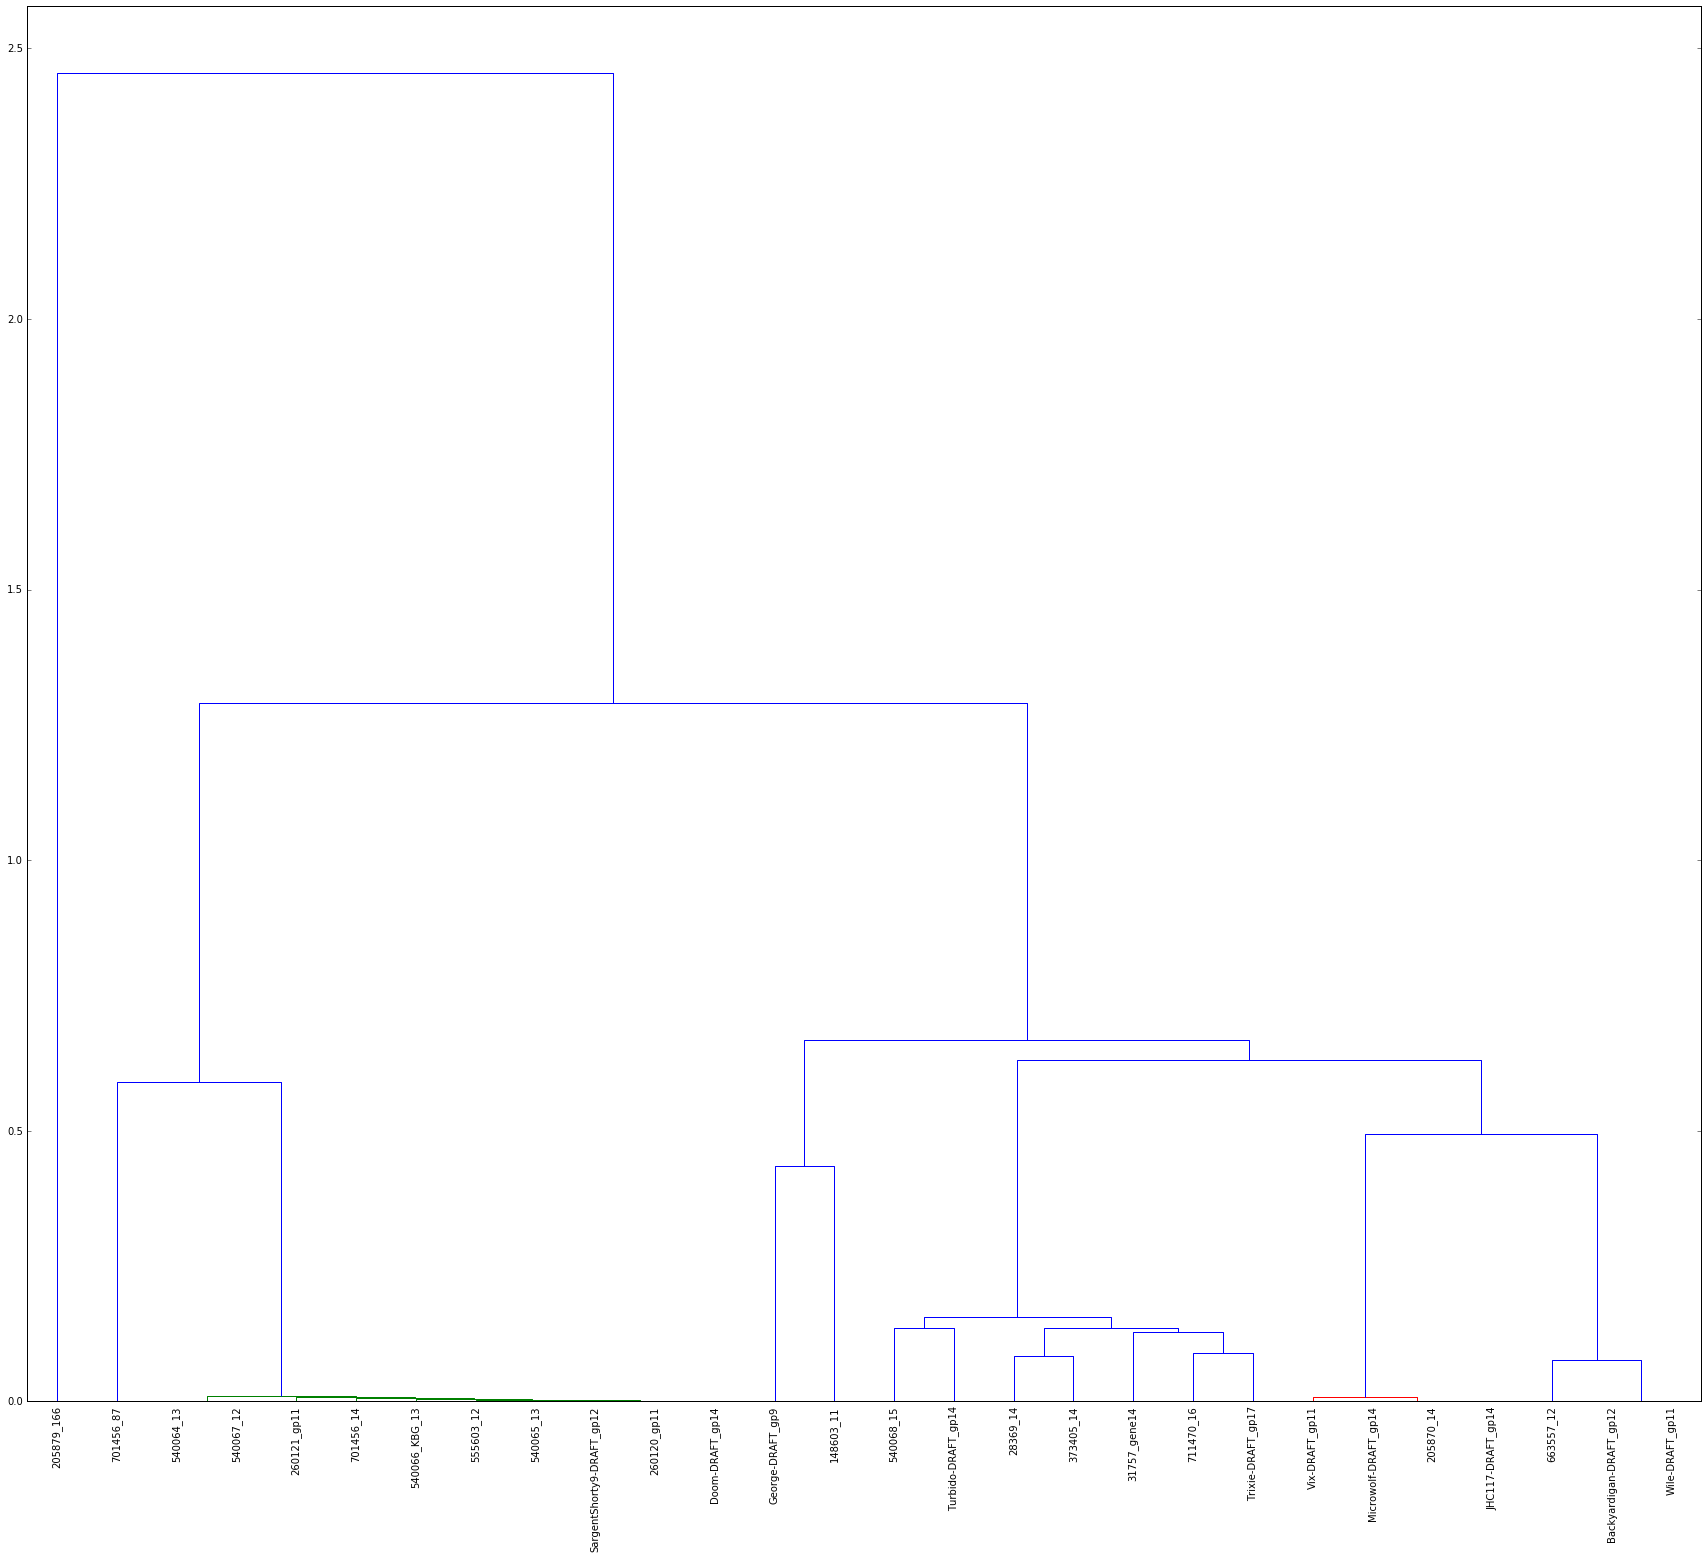

In [18]:
inphinity = Inphinity('sea')
inphinity.verbose = False
inphinity.build_tree('2799')
inphinity.draw_tree()

### Analyze

In [ ]:
print(inphinity.tree.get_terminals())

In [ ]:
print(inphinity.get_list_genes(['Vix-DRAFT_gp11'], True))

In [ ]:
inphinity.print_informations_on_phage('Vix-DRAFT_gp11')

In [ ]:
inphinity.print_informations_on_phages(inphinity.leaves)

## Checking Theory

In [ ]:
inphinity = Inphinity('sea_own')
inphinity.verbose = False
inphinity.build_tree('3352')
inphinity.print_informations_on_phages(inphinity.leaves)

### Testing

In [12]:
inphinity = Inphinity('sea')
inphinity.verbose = False
inphinity.build_tree('2799')
inphinity.print_informations_on_phages(inphinity.leaves)

Number of phages loaded: 113
Creation of the FASTA file
Alignment with MUSCLE
Compute tree
Prepare Tree Fig
Blue: Host come from the original database
Red: Host come from GenBank
Yellow: Host come from Phagedb.org
Mycobacterium phage Pukovnik
********************************             
Gene ID: 540068_15 
Phage ID: 540068 
Phage Name: Pukovnik 
Phage Accession: EU744250.1
HostStrain: Mycobacterium phage Pukovnik
********************************
Mycobacterium smegmatis
********************************             
Gene ID: Turbido-DRAFT_gp14 
Phage ID: Turbido-DRAFT 
Phage Name: Turbido-DRAFT 
Phage Accession: 
HostStrain: Mycobacterium smegmatis
********************************
Mycobacterium phage D29
********************************             
Gene ID: 28369_14 
Phage ID: 28369 
Phage Name: D29 
Phage Accession: AF022214.1
HostStrain: Mycobacterium phage D29
********************************
Mycobacterium phage Che12
********************************             
Gene ID: 373405_14 